Files already downloaded and verified
Files already downloaded and verified
Epoch 1/2: Train Loss = 2.3488, Train Acc = 0.00%, Test Loss = 8.0373, Test Acc = 9.06%
Epoch 2/2: Train Loss = 19.8707, Train Acc = 10.00%, Test Loss = 210.7271, Test Acc = 10.00%
Epoch 1/2: Train Loss = 132.7297, Train Acc = 9.00%, Test Loss = 359.9088, Test Acc = 10.00%
Epoch 2/2: Train Loss = 108.4797, Train Acc = 11.00%, Test Loss = 149.3829, Test Acc = 10.22%
Epoch 1/2: Train Loss = 11.3572, Train Acc = 10.00%, Test Loss = 2.3327, Test Acc = 10.26%
Epoch 2/2: Train Loss = 2.3034, Train Acc = 12.50%, Test Loss = 2.2553, Test Acc = 17.13%
Epoch 1/2: Train Loss = 2.2099, Train Acc = 15.74%, Test Loss = 2.1095, Test Acc = 19.09%
Epoch 2/2: Train Loss = 2.1499, Train Acc = 16.99%, Test Loss = 2.0792, Test Acc = 21.08%
Epoch 1/2: Train Loss = 2.0268, Train Acc = 20.72%, Test Loss = 1.8751, Test Acc = 28.12%
Epoch 2/2: Train Loss = 1.9102, Train Acc = 24.32%, Test Loss = 1.8701, Test Acc = 24.95%


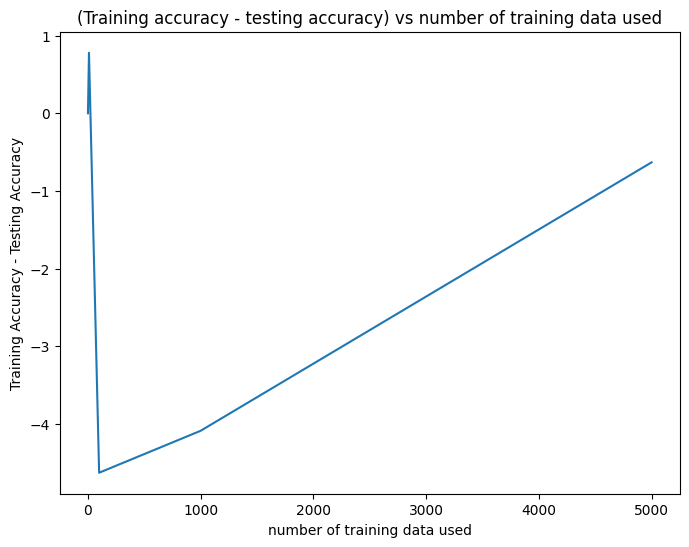

In [4]:
# Now train only on a subset of the CIFAR10 training dataset. Use the below subset conditions. Keep the full CIFAR10 testing set intact. Repeat the above experiment and tune the hyper-parameters as best as you can.
# 1. 1 instance per class, a total of 10 train images only.
# 2. 10 instances per class
# 3. 100 instances per class
# 4. 1000 instances per class
# 5. full train data set

# Plot the (Training accuracy - testing accuracy) vs number of training data used.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Define the neural network architecture with increased depth
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network, loss function, and optimizer
net = DeepNet().to(device)  # Use the deeper network
criterion = nn.CrossEntropyLoss()
# Add weight decay (L2 regularization) to the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-4)  # Adjust weight decay as needed
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Define data augmentation transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image data
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define a list of training dataset sizes to loop through
train_data_sizes = [1, 10, 100, 1000, None]  # None means using the full dataset
# Lists to store results
train_acc_diffs = []
test_accs = []

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)

class_indices = []
for class_index in range(10):
    indices = [i for i, (_, label) in enumerate(trainset) if label == class_index]
    class_indices.append(indices)
    
for train_data_size in train_data_sizes:
   
    # Create a subset of the training dataset
    subset_indices = []
    for class_index in range(10):
        subset_indices.extend(class_indices[class_index][:train_data_size])

    subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(subset_indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=subset_sampler)

    # Training loop
    num_epochs = 50
    train_loss_values = []
    train_acc_values = []
    test_loss_values = []
    test_acc_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss_values.append(running_loss / len(trainloader))
        train_acc_values.append(100 * correct / total)

        # Test the network
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Update the learning rate for this epoch
        scheduler.step()
        
        test_loss_values.append(test_loss / len(testloader))
        test_acc_values.append(100 * correct / total)
        net.train()

        print(f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss = {train_loss_values[-1]:.4f}, Train Acc = {train_acc_values[-1]:.2f}%, "
            f"Test Loss = {test_loss_values[-1]:.4f}, Test Acc = {test_acc_values[-1]:.2f}%")

    train_acc_diffs.append([a - b for a, b in zip(train_acc_values, test_acc_values)])
    test_accs.append(test_acc_values)
    
train_data_size_plot = []
train_acc_diffs_final = []
# Plot (Training accuracy - testing accuracy) vs number of training data used
plt.figure(figsize=(8, 6))
for i, train_data_size in enumerate(train_data_sizes):
    if train_data_size is None:
        train_data_size_plot.append(5000)
    else:
        train_data_size_plot.append(train_data_size)    
    train_acc_diffs_final.append(train_acc_diffs[i][-1])
        
plt.plot(train_data_size_plot, train_acc_diffs_final)
plt.xlabel('number of training data used')
plt.ylabel('Training Accuracy - Testing Accuracy')
plt.title('(Training accuracy - testing accuracy) vs number of training data used')
plt.show()
